In [45]:
# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pickle

# get rid of warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load the data file (with new features already engineered)
df = pd.read_pickle('data/w_eng_features.pkl')

In [3]:
df.head(50)

,air_quality,rel_humidity,avg_num_clear_days,pct_area_water,rainfall_inches,temp_f,highest_point_ft,mean_elevation_ft,happiness_avg,HM__x__RF,TM__x__RF,HP__x__ME,pct_area_water_bc,mean_elevation_bc,hp_bc,feature_eng_predict,feature_eng_resid
Alabama,46.6,52.0,99.0,3.4,58.3,62.8,2413.0,500.0,53.72,3031.6,3661.24,1206500.0,1.045041,9.396474,19.679026,46.485074,7.234926
Alaska,29.1,64.0,61.0,14.2,22.5,26.6,20310.0,1900.0,54.60,1440.0,598.50,38589000.0,1.100227,12.555791,33.467698,29.296699,25.303301
Arizona,45.4,25.0,193.0,0.3,13.6,60.3,12637.0,4100.0,59.51,340.0,820.08,51811700.0,0.957583,14.630178,29.842066,44.042415,15.467585
Arkansas,43.1,49.0,123.0,2.1,50.6,60.4,2753.0,650.0,52.27,2479.4,3056.24,1789450.0,1.027070,9.976459,20.365059,49.188495,3.081505
California,46.0,62.0,146.0,4.8,22.2,59.4,14505.0,2900.0,62.81,1376.4,1318.68,42064500.0,1.058095,13.671538,30.858547,39.990597,22.819403
Colorado,47.1,35.0,136.0,0.4,15.9,45.1,14440.0,6800.0,60.59,556.5,717.09,98192000.0,0.967552,16.107579,30.824967,40.816312,19.773688
Connecticut,45.0,52.0,82.0,12.6,50.3,49.0,2379.0,500.0,60.55,2615.6,2464.70,1189500.0,1.095502,9.396474,19.606300,42.185590,18.364410
Delaware,46.4,54.0,97.0,21.7,45.7,55.3,447.0,60.0,57.92,2467.8,2527.21,26820.0,1.117153,5.346239,12.391301,37.560522,20.359478
Florida,38.9,57.0,101.0,18.5,54.5,70.7,345.0,100.0,58.84,3106.5,3853.15,34500.0,1.110755,6.226235,11.483207,39.889526,18.950474
Georgia,48.2,50.0,112.0,3.2,50.7,63.5,4784.0,600.0,59.58,2535.0,3219.45,2870400.0,1.042762,9.797496,23.456785,45.848097,13.731903


#### Setting up for modeling:

In [229]:
X = df.loc[:,['air_quality', 'rel_humidity', 'avg_num_clear_days',
                     'pct_area_water', 'rainfall_inches', 'temp_f',
                     'highest_point_ft', 'mean_elevation_ft', 'HM__x__RF',
                     'TM__x__RF', 'HP__x__ME', 'pct_area_water_bc', 
                      'mean_elevation_bc', 'hp_bc']]

y = df['happiness_avg', 'avg_num_clear_days']

# create overall quality squared term, which we expect to 
# help based on the relationship we see in the pair plot 

In [687]:
X = df.loc[:,['mean_elevation_bc', 'air_quality', 'pct_area_water_bc', 'HM__x__RF', 'temp_f']]

y = df['happiness_avg']

# THIS IS A GOOD MIXTURE

In [4]:
X = df.loc[:,['mean_elevation_bc', 'air_quality', 'pct_area_water_bc', 'temp_f']]

y = df['happiness_avg']

In [5]:
## Split the data 80 - 20 train_val/test

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)
X_train_val.shape

(40, 4)

In [6]:
## Scale the data
std = StandardScaler()
std.fit(X_train_val.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [7]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train_val.values)
X_te = std.transform(X_test.values)

In [8]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [9]:
#Mean Squared Error (MSE)
def mse(y_true, y_pred):
    return np.mean(np.square(y_pred - y_true)) 

In [10]:
#Adjusted R-squared
def get_adj_r2(r2, n, p):
    return 1-(1-r2)*(n-1)/(n-1-p)

In [11]:
def make_resid_plot(actual, prediction):
    resid = actual - prediction
    with sns.axes_style('white'):
        fig, ax = plt.subplots(figsize=(10,6))
        stats.probplot(resid, dist="norm", plot=plt)
        plt.title("Normal Q-Q plot")

## Run a LassoCV Model

In [12]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec_l = np.logspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec_l, cv=4)
lasso_model.fit(X_tr, y_train_val)

LassoCV(alphas=array([1.00000e-02, 1.04737e-02, ..., 9.54772e+01, 1.00000e+02]),
    copy_X=True, cv=4, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=None, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [13]:
# This is the best LASSO alpha value it found
lasso_model.alpha_

0.15343684089300125

In [14]:
list(zip(X_train_val.columns, lasso_model.coef_))

[('mean_elevation_bc', 2.222349473482037),
 ('air_quality', -0.0),
 ('pct_area_water_bc', 1.6876537335907997),
 ('temp_f', 0.0)]

In [15]:
# Make predictions on the test set using the LASSO model
test_set_pred_lasso = lasso_model.predict(X_te)
train_val_set_pred_lasso = lasso_model.predict(X_tr)

In [16]:
shape(X_te)

(10, 4)

In [17]:
# Find the MSE and R^2 on the test set using this LASSO model
test_mse = mse(y_test, test_set_pred_lasso)
print('test_rmse: ', np.sqrt(test_mse))

test_rmse:  3.329268345871977


In [18]:
# Find r2 score for LASSO
r2_lasso = r2_score(y_test, test_set_pred_lasso)
r2_lasso

-0.0057772812163250364

In [19]:
r2_lasso_in_sample = r2_score(y_train_val, train_val_set_pred_lasso)
r2_lasso_in_sample

0.36486397226022804

In [20]:
# Find adjusted r2 score for LASSO
adj_r2_lasso = get_adj_r2(r2_lasso, X.shape[0], X.shape[1])
adj_r2_lasso

-0.09517970621333172

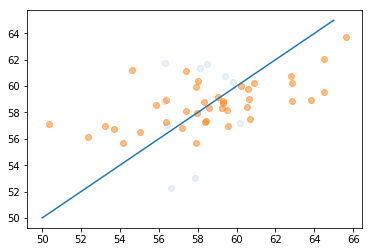

In [21]:
plt.scatter(test_set_pred_lasso, y_test, alpha = 0.1)
plt.scatter(y_train_val, train_val_set_pred_lasso, alpha = 0.5)
plt.plot(np.linspace(50,65,1000), np.linspace(50,65,1000))

In [22]:
sns.set(font='sans-serif', font_scale=1.25, palette="bright")

NameError: name 'train_val_set_pred_ridge' is not defined

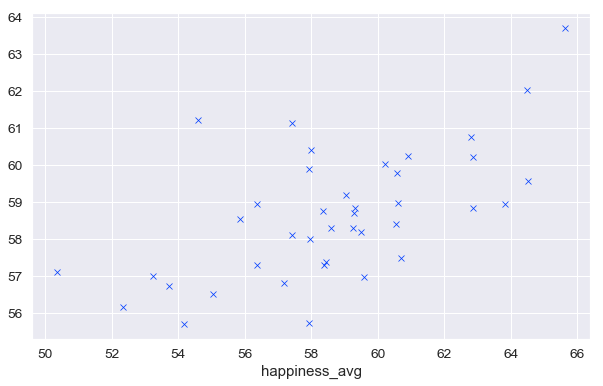

In [23]:
#Make a pretty seaborn plot:
fig, ax = plt.subplots(figsize=(10,6))
# sns.scatterplot(x=y_test, y=test_set_pred_lasso)
sns.scatterplot(x=y_train_val, y=train_val_set_pred_lasso, marker = 'x')
sns.scatterplot(x=y_train_val, y=train_val_set_pred_ridge)
sns.lineplot(np.linspace(50,67,1000), np.linspace(50,67,1000), color='green')

ax.legend(labels=["Perfect Prediction", "Lasso Prediction", "Ridge Prediction"], loc = 4)
ax.set(xlabel='True Happiness', ylabel='Predicted Happiness', title='Lasso vs. Ridge Regression')
plt.savefig('data/lasso_v_ridge.png', dpi=100)
plt.show()

In [24]:
# make_resid_plot(y_train_val, train_val_set_pred_lasso)

## Run a RidgeCV Model

In [25]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

# alphavec_r = 10**np.linspace(-2,0,400)
alphavec_r = np.logspace(-2,2,200)
# alpha = 57

ridge_model = RidgeCV(alphas=alphavec_r, cv=4)
ridge_model.fit(X_tr, y_train_val)

RidgeCV(alphas=array([1.00000e-02, 1.04737e-02, ..., 9.54772e+01, 1.00000e+02]),
    cv=4, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [26]:
# This is the best RIDGE alpha value found
ridge_model.alpha_

0.01

In [27]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train_val.columns, ridge_model.coef_))

[('mean_elevation_bc', 2.841138639028983),
 ('air_quality', 0.15584483950365646),
 ('pct_area_water_bc', 2.2833538263224713),
 ('temp_f', 0.22895946662209116)]

In [28]:
# Make predictions on the test set using the RIDGE model
test_set_pred_ridge = ridge_model.predict(X_te)
train_val_set_pred_ridge = ridge_model.predict(X_tr)

In [29]:
# Find the MSE and R^2 on the test set using this RIDGE model
# use mean squared error
test_mse = mse(y_test, test_set_pred_ridge)
train_val_mse = mse(y_train_val, train_val_set_pred_ridge)
print('test_rmse: ', np.sqrt(test_mse))
print('train_val_rmse: ', np.sqrt(train_val_mse))
print('total_mse: ', np.sqrt(test_mse)+np.sqrt(train_val_mse))

test_rmse:  3.5086672852190928
train_val_rmse:  2.6645074823537818
total_mse:  6.173174767572874


In [30]:
# Find r2 score for RIDGE
r2_ridge = r2_score(y_test, test_set_pred_ridge)
r2_ridge

-0.1170911039536573

In [31]:
# THIS IS THE MONEY
r2_ridge_in_sample = r2_score(y_train_val, train_val_set_pred_ridge)
r2_ridge_in_sample

0.382137542263568

In [32]:
# Find adjusted r2 score for LASSO
adj_r2_ridge = get_adj_r2(r2_ridge, X.shape[0], X.shape[1])
adj_r2_ridge

-0.21638809097176015

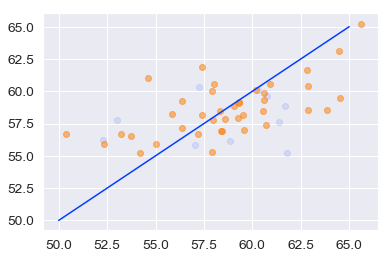

In [33]:
plt.scatter(y_test, test_set_pred_ridge, alpha = 0.1)
plt.scatter(y_train_val, train_val_set_pred_ridge, alpha = 0.5)
plt.plot(np.linspace(50,65,1000), np.linspace(50,65,1000))

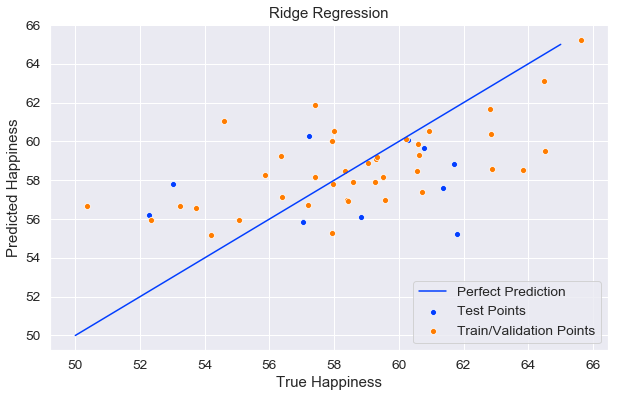

In [34]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x=y_test, y=test_set_pred_ridge)
sns.scatterplot(x=y_train_val, y=train_val_set_pred_ridge)
sns.lineplot(np.linspace(50,65,1000), np.linspace(50,65,1000))

ax.legend(labels=["Perfect Prediction","Test Points","Train/Validation Points"], loc = 4)
ax.set(xlabel='True Happiness', ylabel='Predicted Happiness', title='Ridge Regression')
plt.show()

In [35]:
#Pickle the model
pickle.dump(ridge_model, 'data/model_1')

TypeError: file must have a 'write' attribute

In [1086]:
# make_resid_plot(y_train_val, train_val_set_pred_ridge)

# RidgeCV is being weird. Let's try GridSearch instead

In [37]:
# Grid Search for Algorithm Tuning

# Use the same list of alphas as I did for RidgeCV (alphavec_r)

# create and fit a ridge regression model, testing each alpha
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphavec_r))
grid.fit(X_tr, y_train_val)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([1.00000e-02, 1.04737e-02, ..., 9.54772e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
0.2566501342334675
1.552225357427048


# OLS in scikit-learn

In [38]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
ols_model = LinearRegression()
ols_model.fit(X_tr, y_train_val)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [39]:
list(zip(X_train_val.columns, ols_model.coef_))

[('mean_elevation_bc', 2.843832578559767),
 ('air_quality', 0.15695454514999585),
 ('pct_area_water_bc', 2.286009515262642),
 ('temp_f', 0.22951664759438395)]

In [40]:
# Make predictions on the test set using the ols model
test_set_pred_ols = ols_model.predict(X_te)
train_val_set_pred_ols = ols_model.predict(X_tr)

In [44]:
# Find the RMSE and R^2 on the test set using this ols model
test_mse = mse(y_test, test_set_pred_ols)
print('OLS Model test_rmse: ', np.sqrt(test_mse))

OLS Model test_rmse:  3.5095683367363137


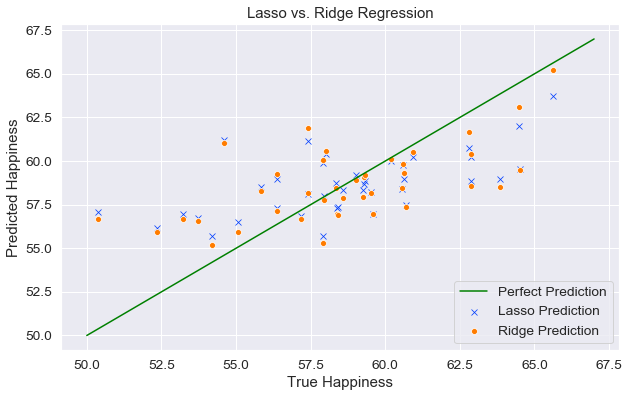

In [42]:
#Make a pretty seaborn plot:
fig, ax = plt.subplots(figsize=(10,6))
# sns.scatterplot(x=y_test, y=test_set_pred_lasso)
sns.scatterplot(x=y_train_val, y=train_val_set_pred_lasso, marker = 'x')
sns.scatterplot(x=y_train_val, y=train_val_set_pred_ridge)
# sns.scatterplot(x=y_train_val, y=train_val_set_pred_ols, marker = '+')
sns.lineplot(np.linspace(50,67,1000), np.linspace(50,67,1000), color='green')

ax.legend(labels=["Perfect Prediction", "Lasso Prediction", "Ridge Prediction"], loc = 4)
ax.set(xlabel='True Happiness', ylabel='Predicted Happiness', title='Lasso vs. Ridge Regression')
plt.savefig('data/lasso_v_ridge.png', dpi=100)
plt.show()

# Try ElasticNet

In [50]:
# create and fit a ridge regression model, testing each alpha
model_EN = ElasticNet()
l1_ratio_vec = np.linspace(0.01,0.99, 99)
grid_EN = GridSearchCV(estimator=model_EN, param_grid=dict(alpha=alphavec_r, l1_ratio=l1_ratio_vec))
grid_EN.fit(X_tr, y_train_val)
print(grid_EN)
# summarize the results of the grid search
print(grid_EN.best_score_)
print(grid_EN.best_estimator_.alpha)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([1.00000e-02, 1.04737e-02, ..., 9.54772e+01, 1.00000e+02]), 'l1_ratio': array([0.01, 0.02, ..., 0.98, 0.99])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
0.2676949673394276
0.11097524964120721


In [59]:
# create and fit a ridge regression model, testing each alpha
model_EN = ElasticNet()
l1_ratio_vec = np.linspace(0.01,0.99, 99)
grid_EN = GridSearchCV(estimator=model_EN, param_grid=dict(alpha=alphavec_r, l1_ratio=l1_ratio_vec), cv = 4)
grid_EN.fit(X_tr, y_train_val)
print(grid_EN)
# summarize the results of the grid search
print(grid_EN.best_score_)
print(grid_EN.best_estimator_.alpha)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([1.00000e-02, 1.04737e-02, ..., 9.54772e+01, 1.00000e+02]), 'l1_ratio': array([0.01, 0.02, ..., 0.98, 0.99])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
0.2537074392201385
0.13987131026472385


In [60]:
print(grid_EN.best_estimator_.alpha)
print(grid_EN.best_estimator_.l1_ratio)

0.13987131026472385
0.99


In [69]:
EN_model = ElasticNet(alpha = grid_EN.best_estimator_.alpha, l1_ratio = grid_EN.best_estimator_.l1_ratio)

EN_model.fit(X_tr, y_train_val)

ElasticNet(alpha=0.13987131026472385, copy_X=True, fit_intercept=True,
      l1_ratio=0.99, max_iter=1000, normalize=False, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)

In [70]:
list(zip(X_train_val.columns, EN_model.coef_))

[('mean_elevation_bc', 2.255887844149948),
 ('air_quality', -0.0),
 ('pct_area_water_bc', 1.7216479693749043),
 ('temp_f', 0.0)]

In [71]:
# Make predictions on the test set and train set using the ElasticNET model
test_set_pred_EN = EN_model.predict(X_te)
train_val_set_pred_EN = EN_model.predict(X_tr)

In [72]:
# Find the MSE and R^2 on the test set using this RIDGE model
# use mean squared error
test_mse_EN = mse(y_test, test_set_pred_EN)
train_val_mse_EN = mse(y_train_val, train_val_set_pred_EN)
print('test_rmse: ', np.sqrt(test_mse_EN))
print('train_val_rmse: ', np.sqrt(train_val_mse_EN))
print('total_mse: ', np.sqrt(test_mse_EN)+np.sqrt(train_val_mse_EN))

test_rmse:  3.334201076080501
train_val_rmse:  2.6978095498434778
total_mse:  6.032010625923979


In [73]:
# Find r2 score for RIDGE
r2_EN = r2_score(y_test, test_set_pred_EN)
r2_EN

-0.008759860452506318

In [74]:
# THIS IS THE MONEY
r2_EN_in_sample = r2_score(y_train_val, train_val_set_pred_EN)
r2_EN_in_sample

0.36659644770743005

In [75]:
# Find adjusted r2 score for LASSO
adj_r2_EN = get_adj_r2(r2_EN, X.shape[0], X.shape[1])
adj_r2_EN

-0.09842740360384017

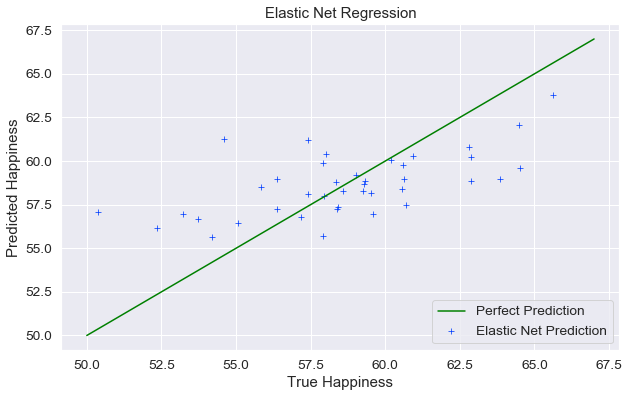

In [78]:
#Make a pretty seaborn plot:
fig, ax = plt.subplots(figsize=(10,6))
# sns.scatterplot(x=y_train_val, y=train_val_set_pred_lasso, marker = 'x')
# sns.scatterplot(x=y_train_val, y=train_val_set_pred_ridge)
sns.scatterplot(x=y_train_val, y=train_val_set_pred_EN, marker = '+')
sns.lineplot(np.linspace(50,67,1000), np.linspace(50,67,1000), color='green')

ax.legend(labels=["Perfect Prediction", "Elastic Net Prediction"], loc = 4)
ax.set(xlabel='True Happiness', ylabel='Predicted Happiness', title='Elastic Net Regression')
plt.savefig('data/elastic_net.png', dpi=100)
plt.show()

# Putting Things Back Together

In [97]:
# Make a new df with the relevant features I looked at and with true happiness from TRAIN and VAL sets
df_train_val_with_predictions = X_train_val
df_train_val_with_predictions['True Happiness'] = y_train_val

In [102]:
# Add my predicted happiness as a column to the df
df_train_val_with_predictions['Predicted Happiness'] = train_val_set_pred_lasso

In [108]:
df_train_val_with_predictions

,mean_elevation_bc,air_quality,pct_area_water_bc,temp_f,True Happiness,Predicted Happiness
West Virginia,11.957282,47.6,0.991999,51.8,50.37,57.098711
Utah,15.782429,51.2,1.042762,48.6,64.48,62.025533
Rhode Island,7.513820,43.7,1.134263,50.1,57.41,58.120350
Pennsylvania,11.198357,45.6,1.037762,48.8,57.95,57.992648
Arizona,14.630178,45.4,0.957583,60.3,59.51,58.198941
Delaware,5.346239,46.4,1.117153,55.3,57.92,55.719154
North Carolina,10.143758,46.5,1.085235,59.0,59.30,58.694600
Nevada,15.476607,42.1,0.987242,49.9,57.93,59.906743
Missouri,10.449145,44.0,1.012187,54.5,55.05,56.503696
South Dakota,12.935957,39.6,1.019286,45.2,62.87,58.838529


### Do the same for my test set:

In [106]:
# Make a new df with the relevant features I looked at and with true happiness from TEST set
df_test_with_predictions = X_test
df_test_with_predictions['True Happiness'] = y_test

In [109]:
# Add my predicted happiness as a column to the df
df_test_with_predictions['Predicted Happiness'] = test_set_pred_lasso

In [110]:
df_test_with_predictions

,mean_elevation_bc,air_quality,pct_area_water_bc,temp_f,True Happiness,Predicted Happiness
Oklahoma,11.603468,43.5,1.023376,59.6,53.03,57.852050
Massachusetts,9.396474,41.4,1.124603,47.9,60.78,59.383999
Oregon,14.024407,36.1,1.032019,48.4,57.22,60.183072
Iowa,11.198357,37.6,0.987242,47.8,61.79,56.299338
Nebraska,13.377733,37.0,0.987242,48.8,61.37,58.136980
Arkansas,9.976459,43.1,1.027070,60.4,52.27,56.603972
New York,10.970990,40.4,1.098519,45.4,60.28,59.837353
Indiana,10.143758,47.5,1.017064,51.7,57.03,56.409675
Florida,6.226235,38.9,1.110755,70.7,58.84,56.246719
Maryland,8.637899,47.0,1.117338,54.2,61.69,58.500869


In [111]:
df_with_predictions = pd.concat([df_train_val_with_predictions, df_test_with_predictions])

In [124]:
df_with_predictions.sort_values('Predicted Happiness', ascending=False, inplace = True)

In [125]:
df_with_predictions.head(15)

,mean_elevation_bc,air_quality,pct_area_water_bc,temp_f,True Happiness,Predicted Happiness
Hawaii,13.790657,21.2,1.143237,70.0,65.62,63.713744
Utah,15.782429,51.2,1.042762,48.6,64.48,62.025533
Alaska,12.555791,29.1,1.100227,26.6,54.60,61.230922
Michigan,10.722779,42.5,1.143536,44.4,57.41,61.136929
California,13.671538,46.0,1.058095,59.4,62.81,60.759547
Wyoming,16.062976,45.0,0.987242,42.0,58.00,60.401168
Wisconsin,11.087043,39.5,1.108076,43.1,60.92,60.255560
Idaho,15.198571,44.3,1.003437,44.4,62.86,60.215132
Oregon,14.024407,36.1,1.032019,48.4,57.22,60.183072
Washington,12.271977,33.5,1.071446,48.3,60.21,60.026936


In [128]:
df_with_predictions.std(axis=0)

mean_elevation_bc      2.597735
air_quality            5.261683
pct_area_water_bc      0.051119
temp_f                 8.706581
True Happiness         3.411375
Predicted Happiness    1.717226
dtype: float64